In [1]:
import sys
import os
import time
import codecs
import pandas as pd
from pprint import pprint

sys.path.append("/Users/Bya/git/predictEPL/utils/")
sys.path.append("/Users/Bya/git/predictEPL/config/")

import emolex
import paths
import tokenizer
import useful_methods as my_methods
import train_datas

In [44]:
%pylab inline
%matplotlib inline

import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas
import sklearn
import pickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### Choose : DATA

In [3]:
##########################################################
# Step 1. Prepare Data => Soccer Hash Emolex
dic_emolex_soccer, y = emolex.EmolexSoccerDic()

# Read Hash Emolex CSV
dfHashEmolex = train_datas.HashEmolexAllRead()

# Labeling Emolex 8 cat => POS, NEG
texts = []
sentiments = []

for i in range(len(dfHashEmolex)):
    text = dfHashEmolex.iloc[i]['text']
    sentiment = dfHashEmolex.iloc[i]['sentiments'].split(',')
    
    for sent in sentiment:
        if sent in ['anger', 'disgust', 'fear', 'sadness', 'negative']:
            texts.append(text)
            sentiments.append(0) # 0 is negative
            break

        elif sent in ['anticipation', 'joy', 'positive', 'trust']:
            texts.append(text)
            sentiments.append(1) # 1 is negative
            break

# Create New POS, NEG dataframe
dfTwitter = pd.DataFrame(columns=['tweet', 'sentiment'])
dfTwitter['tweet'] = texts
dfTwitter['sentiment'] = sentiments
dfTwitter['length'] = [len(text) for text in dfTwitter['tweet']]

print("POS: ", len(dfTwitter[dfTwitter.sentiment == 1]))
print("NEG: ", len(dfTwitter[dfTwitter.sentiment == 0]))
print("\nAll: ", len(dfTwitter))

All Words: 14136
POS:  3207
NEG:  4008

All:  7215


In [ ]:
##########################################################
# Step 1. Prepare Data => SemEval Tweet PN

# Read Data
dfTwitter = train_datas.TweetPnEqualRead()

# Change sentiment to number
label_dic = {
    'positive': 1,
    'negative': 0,
}

dfTwitter.sentiment = [label_dic[sentiment] for sentiment in list(dfTwitter.sentiment)]

# Adding 'length' column
dfTwitter['length'] = [len(text) for text in dfTwitter['tweet']]

In [ ]:
##########################################################
# Step 1. Prepare Data => Movie Short reviews

os.chdir(paths.READ_PATH_REVIEW_SHORT)
dfTwitter = my_methods.csv_dic_df("short_movie_reviews.csv")

# Adding 'length' column
dfTwitter['tweet'] = dfTwitter['review']
dfTwitter['length'] = [len(text) for text in dfTwitter['tweet']]

### Tunning Starts

In [ ]:
##########################################################
# Step 2: Data to Vectors

# Bag Of Word(bof), Porter Stemmer
print("Bag Of Word(bof), Porter Stemmer:")
%time bow_transformer = CountVectorizer(analyzer=tokenizer.Stem).fit(dfTwitter['tweet'])



# The bag-of-words counts for the entire Tweets corpus are a large,
# sparse matrix:
tweets_bow = bow_transformer.transform(dfTwitter['tweet'])
print('\nsparse matrix shape:', tweets_bow.shape)
print('number of non-zeros:', tweets_bow.nnz)
print('sparsity: %.2f%%' % (100.0 * tweets_bow.nnz / (tweets_bow.shape[0] * tweets_bow.shape[1])))



# And finally, after the counting,
# the term weighting and normalization can be done with TF-IDF,
# using scikit-learn's TfidfTransformer:
tfidf_transformer = TfidfTransformer().fit(tweets_bow)


# To transform the entire bag-of-words corpus into TF-IDF corpus at once:
tweets_tfidf = tfidf_transformer.transform(tweets_bow)
print("\nTF-IDF(bow)\n", tweets_tfidf.shape)

In [4]:
##########################################################
# Step 3: Run Expirements & Tune Params


# Split data Train and Test data
tweets_train, tweets_test, sentiment_train, sentiment_test = \
    train_test_split(dfTwitter['tweet'], dfTwitter['sentiment'], test_size=0.2)

print("Train data: ", len(tweets_train), "\nTest data: ", len(tweets_test),
      "\nAll data: ", len(sentiment_train) + len(sentiment_test))



# Let's recap the entire pipeline up to this point,
# putting the steps explicitly into scikit-learn's Pipeline:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=tokenizer.Stem)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])


##############################################################
# Tune Parameters
params = {
#     'tfidf__use_idf': (True),
    'bow__analyzer': (tokenizer.StemNoStops, tokenizer.LemmaNoStops,
                      tokenizer.StemNoEnglishStops, tokenizer.LemmaNoEnglishStops,
                      tokenizer.StemNoSoccerStops, tokenizer.LemmaNoSoccerStops,
                      tokenizer.StemNoNegation, tokenizer.LemmaNoNegation,
                      tokenizer.Stem, tokenizer.Lemma),
}

grid = GridSearchCV(
    pipeline,  # pipeline from above
    params,  # parameters to tune via cross validation
    refit=True,  # fit using all available data at the end, on the best found param combination
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(sentiment_train, n_folds=10),  # what type of cross validation to use
)

Train data:  5772 
Test data:  1443 
All data:  7215


In [7]:
# Let's recap the entire pipeline up to this point,
# putting the steps explicitly into scikit-learn's Pipeline:
pipelineLog = Pipeline([
    ('bow', CountVectorizer(analyzer=tokenizer.Stem)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LogisticRegression()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])


##############################################################
# Tune Parameters
params = {
#     'tfidf__use_idf': (True),
    'bow__analyzer': (tokenizer.StemNoStops, tokenizer.LemmaNoStops,
                      tokenizer.StemNoEnglishStops, tokenizer.LemmaNoEnglishStops,
                      tokenizer.StemNoSoccerStops, tokenizer.LemmaNoSoccerStops,
                      tokenizer.StemNoNegation, tokenizer.LemmaNoNegation,
                      tokenizer.Stem, tokenizer.Lemma),
}

gridLog = GridSearchCV(
    pipelineLog,  # pipeline from above
    params,  # parameters to tune via cross validation
    refit=True,  # fit using all available data at the end, on the best found param combination
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(sentiment_train, n_folds=10),  # what type of cross validation to use
)

In [5]:
########################################################
%time nb_detector = grid.fit(tweets_train, sentiment_train)
pprint(nb_detector.grid_scores_)

CPU times: user 5.85 s, sys: 218 ms, total: 6.07 s
Wall time: 4min 15s
[mean: 0.78465, std: 0.01329, params: {'bow__analyzer': <function StemNoStops at 0x112497d90>},
 mean: 0.79002, std: 0.01289, params: {'bow__analyzer': <function LemmaNoStops at 0x11252c598>},
 mean: 0.78586, std: 0.00970, params: {'bow__analyzer': <function StemNoEnglishStops at 0x112497048>},
 mean: 0.78967, std: 0.01190, params: {'bow__analyzer': <function LemmaNoEnglishStops at 0x11252c620>},
 mean: 0.81029, std: 0.01145, params: {'bow__analyzer': <function StemNoSoccerStops at 0x11252c400>},
 mean: 0.81480, std: 0.00842, params: {'bow__analyzer': <function LemmaNoSoccerStops at 0x11252c6a8>},
 mean: 0.81410, std: 0.01233, params: {'bow__analyzer': <function StemNoNegation at 0x11252c378>},
 mean: 0.81843, std: 0.01023, params: {'bow__analyzer': <function LemmaNoNegation at 0x11252c730>},
 mean: 0.82415, std: 0.01251, params: {'bow__analyzer': <function Stem at 0x11252c488>},
 mean: 0.82987, std: 0.01081, params

In [6]:
nb_detector.best_params_

{'bow__analyzer': <function tokenizer.Lemma>}

In [14]:
predictions = nb_detector.predict(tweets_test)
print("[Test Results]:\n")
print('Accuracy:', accuracy_score(sentiment_test, predictions))
print('Precision:', precision_score(sentiment_test, predictions))
print('Recall:', recall_score(sentiment_test, predictions))

[Test Results]:

Accuracy: 0.808731808732
Precision: 0.904166666667
Recall: 0.653614457831


In [8]:
########################################################
%time log_detector = gridLog.fit(tweets_train, sentiment_train)
pprint(log_detector.grid_scores_)

CPU times: user 6.4 s, sys: 217 ms, total: 6.62 s
Wall time: 4min 16s
[mean: 0.83888, std: 0.01517, params: {'bow__analyzer': <function StemNoStops at 0x112497d90>},
 mean: 0.83836, std: 0.01814, params: {'bow__analyzer': <function LemmaNoStops at 0x11252c598>},
 mean: 0.84685, std: 0.01169, params: {'bow__analyzer': <function StemNoEnglishStops at 0x112497048>},
 mean: 0.84685, std: 0.01176, params: {'bow__analyzer': <function LemmaNoEnglishStops at 0x11252c620>},
 mean: 0.85863, std: 0.01495, params: {'bow__analyzer': <function StemNoSoccerStops at 0x11252c400>},
 mean: 0.85793, std: 0.01977, params: {'bow__analyzer': <function LemmaNoSoccerStops at 0x11252c6a8>},
 mean: 0.86088, std: 0.01215, params: {'bow__analyzer': <function StemNoNegation at 0x11252c378>},
 mean: 0.86071, std: 0.01829, params: {'bow__analyzer': <function LemmaNoNegation at 0x11252c730>},
 mean: 0.86175, std: 0.01230, params: {'bow__analyzer': <function Stem at 0x11252c488>},
 mean: 0.85724, std: 0.01460, params:

In [9]:
log_detector.best_params_

{'bow__analyzer': <function tokenizer.Stem>}

In [13]:
predictions = log_detector.predict(tweets_test)
print("[Test Results]:\n")
print('Accuracy:', accuracy_score(sentiment_test, predictions))
print('Precision:', precision_score(sentiment_test, predictions))
print('Recall:', recall_score(sentiment_test, predictions))

[Test Results]:

Accuracy: 0.84060984061
Precision: 0.871575342466
Recall: 0.76656626506


In [15]:
##########################################################
# Step 3: Save Detecter

os.chdir("/Users/Bya/Dropbox/Research/datas/Detecter/")
with open('log_tweets_pn_detector-20160114.pkl', 'wb') as fout:
    pickle.dump(log_detector, fout)

### Classify

In [17]:
# Read Detecter
os.chdir("/Users/Bya/Dropbox/Research/datas/Detecter/")
with open('log_tweets_pn_detector-20160114.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'utf-8'
    log_detector_reloaded = u.load()
    classifier = log_detector_reloaded
    print(log_detector_reloaded)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 1 ..., 0 0], n_folds=10, shuffle=False, random_state=None),
       error_score='raise',
       estimator=Pipeline(steps=[('bow', CountVectorizer(analyzer=<function Stem at 0x11252c488>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
       ...',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid={'bow__analyzer': (<function StemNoStops at 0x112497d90>, <function LemmaNoStops at 0x11252c598>, <function StemNoEnglishStops at 0x112497048>, <function LemmaNoEnglishStops at 0x11252c620>, <function StemNoSoccerStops at 0x11252c400>, <function LemmaNoSoccerStops at 0x11252c6a8>, <function StemNoNegation at 0x11252c378>, <function Le

In [35]:
for index in range(10):
    tweet = dfTwitter.tweet[index]
    label = dfTwitter.sentiment[index]
    print("\n\n================================")
    print("[Tweet]:\n", tweet)
    print("[Sentiment]: ", label)
    print("\n[Classifier]:")
    print (classifier.predict_proba(tweet)[0], classifier.predict(tweet)[0])



[Tweet]:
 #body #status Dewibet Jkt -  Susunan Pemain… http://t.co/LB1eax7oaX #arsenal #surabaya #TeamK #wanita #dewi http://t.co/JUdCIgyuRw
[Sentiment]:  1

[Classifier]:
[ 0.50781798  0.49218202] 0


[Tweet]:
 BRILLIANT!!!!! @Mo_Farah Simply the best!!!!! #WorldChampion #Athlete #Gooner #Arsenal
[Sentiment]:  1

[Classifier]:
[ 0.53828246  0.46171754] 0


[Tweet]:
 @markvanhartenn yesss #NUFC #Arsenal #HYPE
[Sentiment]:  0

[Classifier]:
[ 0.50781798  0.49218202] 0


[Tweet]:
 #fuck #chelsea #love #arsenal http://t.co/EmNXC1Jesa
[Sentiment]:  1

[Classifier]:
[ 0.50781798  0.49218202] 0


[Tweet]:
 Watching both #Arsenal &amp; #DerbyCounty #Football #Saturday #Afc #Gunners #Rams https://t.co/eOI5O8tNNX
[Sentiment]:  0

[Classifier]:
[ 0.42850398  0.57149602] 1


[Tweet]:
 Good start from the Arsenal #pressure #Arsenal
[Sentiment]:  0

[Classifier]:
[ 0.47713285  0.52286715] 1


[Tweet]:
 Congrats to #mofarah on his 3rd major double #gold, massive achievement, fellow #Gooner makes i

In [36]:
from sklearn.metrics import roc_curve, auc

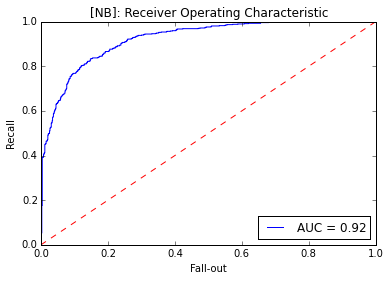

In [42]:
# Receiver Operating Characteristic = ROC curve
# Visualizes a classifier's performance
# for all values of the discrimination threshold. 

# fall out: F = FP / (TN + FP)

# AUC (area under the curve)

predictions_test = nb_detector.predict_proba(tweets_test)

false_positive_rate, recall, thresholds = roc_curve(
    sentiment_test, predictions_test[:, 1])

roc_auc = auc(false_positive_rate, recall)

# Plot
plt.title('[NB]: Receiver Operating Characteristic')
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out')
plt.show()

In [45]:
print('\n\nClassification Report:\n', classification_report(sentiment_test, predictions_test))

ValueError: Mix type of y not allowed, got types {'continuous-multioutput', 'binary'}

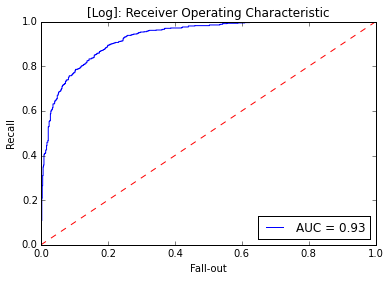

In [40]:
# Receiver Operating Characteristic = ROC curve
# Visualizes a classifier's performance
# for all values of the discrimination threshold. 

# fall out: F = FP / (TN + FP)

# AUC (area under the curve)

predictions_test = log_detector.predict_proba(tweets_test)

false_positive_rate, recall, thresholds = roc_curve(
    sentiment_test, predictions_test[:, 1])

roc_auc = auc(false_positive_rate, recall)

# Plot
plt.title('[Log]: Receiver Operating Characteristic')
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out')
plt.show()